In [2]:
#   IMPORTS PRINCIPAUX
# ===============================

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

from pathlib import Path
from collections import defaultdict
from os import listdir

import kagglehub

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

import mlflow
import mlflow.sklearn



In [3]:

path = kagglehub.dataset_download("emmarex/plantdisease")


In [4]:

EPOCHS = 25
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((256, 256))
image_size = 0
directory_root = path + '/plantvillage/'
width = 256
height = 256
depth = 3


In [5]:

_dr = Path(directory_root).resolve()
print(f"[INFO] directory_root = {_dr}")
print(f"[INFO] Exists: {_dr.exists()}  Is dir: {_dr.is_dir()}")

if _dr.exists() and _dr.is_dir():
    subdirs = [p for p in _dr.iterdir() if p.is_dir()]
    print(f"[INFO] Top-level subfolders: {len(subdirs)}")
    exts = {'.jpg', '.jpeg', '.png', '.bmp'}
    for p in sorted(subdirs)[:8]:
        try:
            files = [f for f in p.iterdir() if f.is_file() and f.suffix.lower() in exts]
            print(f" - {p.name}: {len(files)} images directly inside")
        except Exception as e:
            print(f" - {p.name}: [WARN] error listing -> {e}")
else:
    print("[WARN] directory_root missing or not a folder. Verify dataset download path.")


[INFO] directory_root = /home/vectra/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage
[INFO] Exists: True  Is dir: True
[INFO] Top-level subfolders: 1
 - PlantVillage: 0 images directly inside


In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return image.astype("float32")  # remplace img_to_array
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


In [7]:
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
MAX_PER_CLASS = 2000


def _find_class_dirs(root: Path):
    class_dirs = []
    for p in root.iterdir():
        if not p.is_dir():
            continue

        try:
            imgs_here = any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in p.iterdir())
        except Exception:
            imgs_here = False

        if imgs_here:
            class_dirs.append(p)
            continue

        try:
            for sub in p.iterdir():
                if sub.is_dir():
                    imgs_sub = any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in sub.iterdir())
                    if imgs_sub:
                        class_dirs.append(sub)
        except Exception:
            pass

    return sorted(set(class_dirs), key=lambda x: x.name)


In [8]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root = Path(directory_root)
    if not root.exists() or not root.is_dir():
        raise FileNotFoundError(f"Dataset root not found: {root}")

    class_dirs = _find_class_dirs(root)
    print(f"[INFO] Detected {len(class_dirs)} class folders.")

    per_class_counts = {}
    for cdir in class_dirs:
        try:
            files = [f for f in cdir.iterdir() if f.is_file() and f.suffix.lower() in ALLOWED_EXTS]
        except Exception:
            files = []
        files = sorted(files)[:MAX_PER_CLASS]
        per_class_counts[cdir.name] = len(files)

        for fp in files:
            arr = convert_image_to_array(str(fp))
            if arr is None or (hasattr(arr, "size") and arr.size == 0):
                continue
            image_list.append(arr)
            label_list.append(cdir.name)

    print("[INFO] Image loading completed")
    print("[INFO] Per-class counts (capped):")
    for k, v in sorted(per_class_counts.items()):
        print(f" - {k}: {v}")
    print(f"[INFO] Total images: {len(image_list)}; Total labels: {len(label_list)}")

except Exception as e:
    print(f"Error : {e}")

image_size = len(image_list)


[INFO] Loading images ...
[INFO] Detected 15 class folders.
[INFO] Image loading completed
[INFO] Per-class counts (capped):
 - Pepper__bell___Bacterial_spot: 997
 - Pepper__bell___healthy: 1478
 - Potato___Early_blight: 1000
 - Potato___Late_blight: 1000
 - Potato___healthy: 152
 - Tomato_Bacterial_spot: 2000
 - Tomato_Early_blight: 1000
 - Tomato_Late_blight: 1909
 - Tomato_Leaf_Mold: 952
 - Tomato_Septoria_leaf_spot: 1771
 - Tomato_Spider_mites_Two_spotted_spider_mite: 1676
 - Tomato__Target_Spot: 1404
 - Tomato__Tomato_YellowLeaf__Curl_Virus: 2000
 - Tomato__Tomato_mosaic_virus: 373
 - Tomato_healthy: 1591
[INFO] Total images: 19303; Total labels: 19303


In [ ]:

labels_np = np.array(label_list)
idx = np.arange(len(labels_np))

train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=labels_np
)

label_binarizer = LabelBinarizer()
label_binarizer.fit(labels_np[train_idx])
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))

np_image_list = np.array(image_list, dtype=np.float32) / 255.0

print("[INFO] Splitting data to train, test (stratified)")
x_train = np_image_list[train_idx]
x_test = np_image_list[test_idx]
y_train = label_binarizer.transform(labels_np[train_idx])
y_test = label_binarizer.transform(labels_np[test_idx])
print(f"Train: {x_train.shape}, Test: {x_test.shape}, Classes: {n_classes}")


['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


# Partie ajoutee

In [ ]:

def convert_to_flatten_gray(img_array):
    img_uint8 = (img_array * 255).astype("uint8")
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    gray_small = cv2.resize(gray, (64, 64))
    return gray_small.flatten()


print("[INFO] Creating flattened features...")
X_flat = np.array([convert_to_flatten_gray(img) for img in np_image_list], dtype=np.float32)
print("[INFO] X_flat shape:", X_flat.shape)

X_train_flat = X_flat[train_idx]
X_test_flat = X_flat[test_idx]

y_train_flat = labels_np[train_idx]
y_test_flat = labels_np[test_idx]

[INFO] Creating flattened features...
[INFO] X_flat shape: (8704, 4096)


In [ ]:
print("[INFO] Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)
print("[INFO] Scaling done")


[INFO] Scaling features...
[INFO] Scaling done


In [ ]:
mlflow.set_experiment("plant_disease_random_forest")

param_dist = {
    "n_estimators": [150, 200, 300, 400],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}


rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("[INFO] Training RandomForest...")
search.fit(X_train_scaled, y_train_flat)

best_rf = search.best_estimator_
print("[INFO] Best parameters :", search.best_params_)

# Prédictions du RandomForest sur le jeu de test
y_pred_rf = best_rf.predict(X_test_scaled)


[INFO] Training RandomForest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[INFO] Best parameters : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


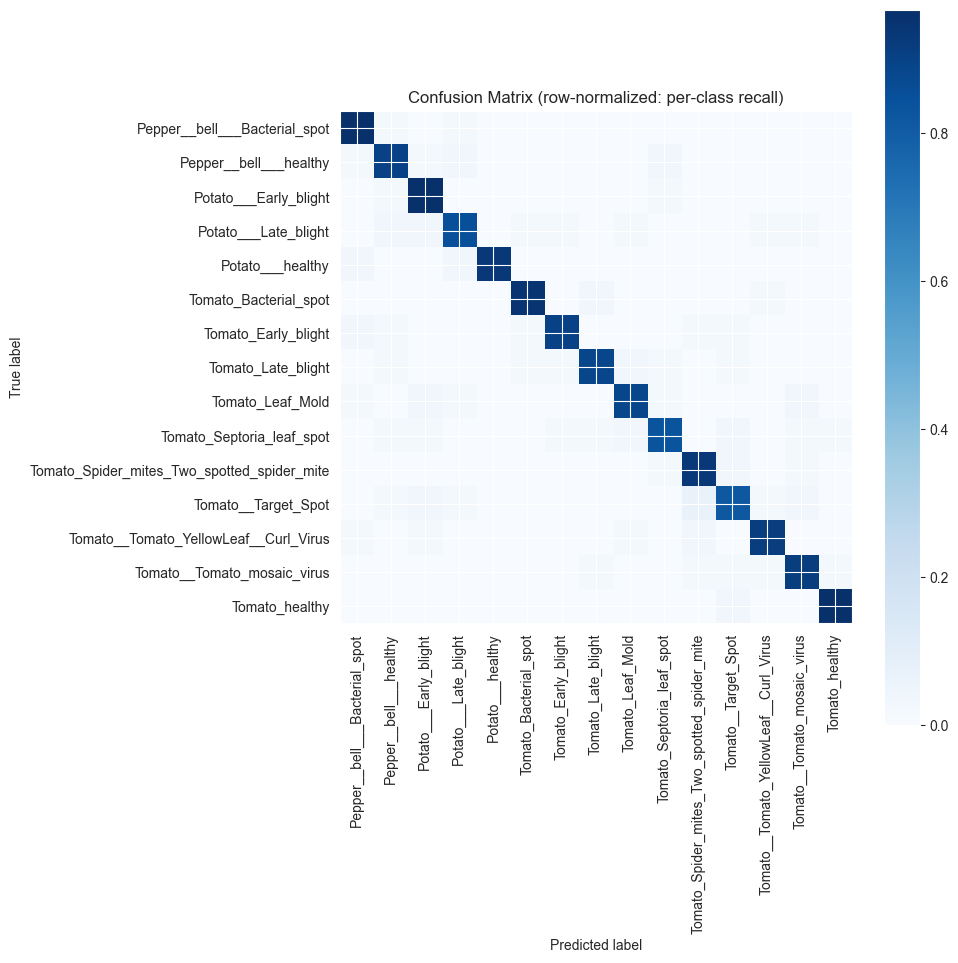

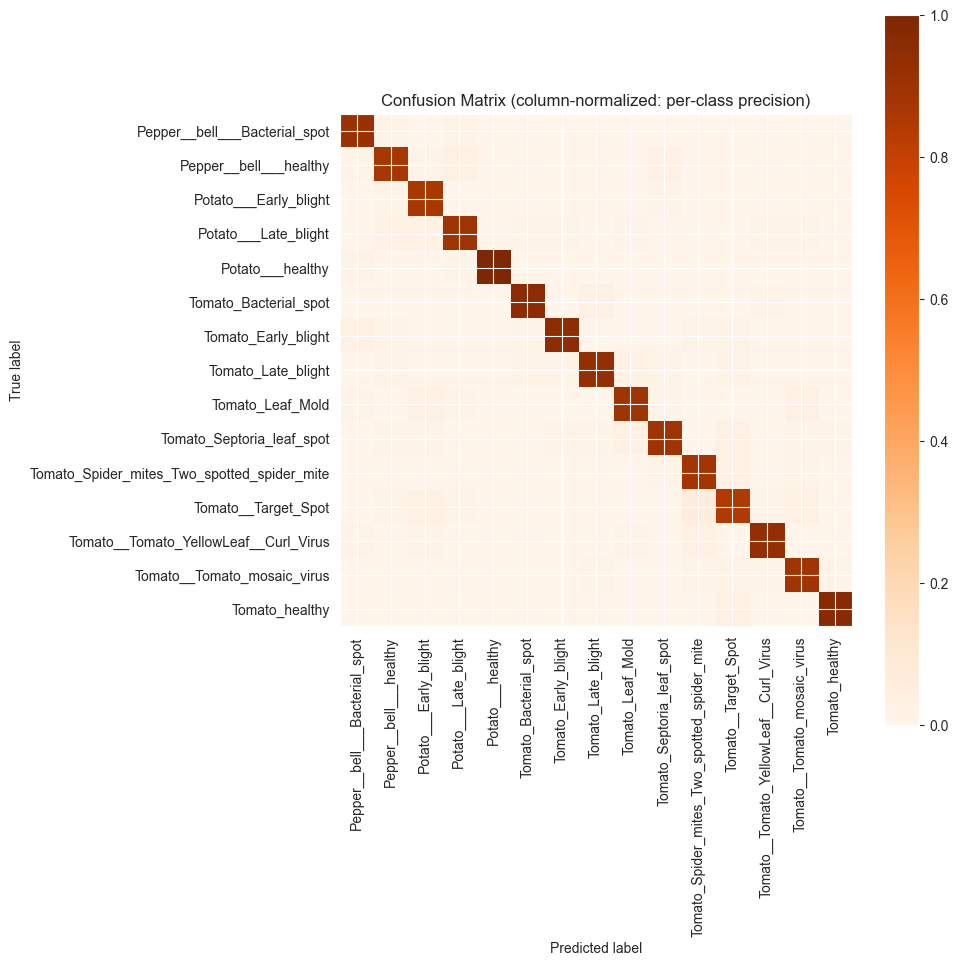

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot      0.906     0.967     0.935       120
                     Pepper__bell___healthy      0.871     0.900     0.885       120
                      Potato___Early_blight      0.866     0.967     0.913       120
                       Potato___Late_blight      0.895     0.850     0.872       120
                           Potato___healthy      1.000     0.934     0.966        61
                      Tomato_Bacterial_spot      0.950     0.950     0.950       120
                        Tomato_Early_blight      0.947     0.900     0.923       120
                         Tomato_Late_blight      0.930     0.883     0.906       120
                           Tomato_Leaf_Mold      0.898     0.883     0.891       120
                  Tomato_Septoria_leaf_spot      0.893     0.833     0.862       120
Tomato_Spider_mites_Two_spotted_spider_mite      0.875     0.933

In [ ]:
#   Confusion matrix and classification report (RandomForest)
#   Version alignée avec le code CNN de ton collègue
#===============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# y_test est one-hot (à cause du LabelBinarizer),
# on récupère donc les indices de classes comme dans le code CNN
y_true = np.argmax(y_test, axis=1)

# y_pred_rf contient des noms de classes (strings),
# on les convertit en indices pour être comparable à y_true
labels = list(label_binarizer.classes_)
num_classes = len(labels)
label_to_idx = {lab: i for i, lab in enumerate(labels)}

y_pred = np.array([label_to_idx[c] for c in y_pred_rf])

# Normalized by true labels (each row sums to 1): highlights recall per class
cm_true = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="true")
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm_true, display_labels=labels)
disp.plot(include_values=False, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix (row-normalized: per-class recall)")
plt.tight_layout()
plt.show()

# Optional: also view prediction-normalized (each column sums to 1): highlights precision per class
cm_pred = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="pred")
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm_pred, display_labels=labels)
disp.plot(include_values=False, cmap="Oranges", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix (column-normalized: per-class precision)")
plt.tight_layout()
plt.show()

# Full per-class metrics (même style que ton collègue)
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# Identify most confused pairs (off-diagonal)
cm_off = cm_true.copy()
np.fill_diagonal(cm_off, 0.0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_off.ravel())[::-1], cm_off.shape))[0]
top_k = 10
print("\nTop confused class pairs (true → predicted) with rates:")
for i, j in pairs[:top_k]:
    if cm_off[i, j] > 0:
        print(f" - {labels[i]} → {labels[j]}: {cm_off[i, j]:.3f}")

In [ ]:
# Equivalent à model.evaluate() en Keras
print("[INFO] Calculating model accuracy...")

# y_test est one-hot, donc on récupère les indices de classes
y_true = np.argmax(y_test, axis=1)

# y_pred_rf sont des strings → on les convertit en indices
label_to_idx = {lab: i for i, lab in enumerate(label_binarizer.classes_)}
y_pred = np.array([label_to_idx[c] for c in y_pred_rf])

# accuracy
acc = accuracy_score(y_true, y_pred)

print(f"Test Accuracy: {acc * 100:.2f}%")


[INFO] Calculating model accuracy...
Test Accuracy: 90.70%


In [ ]:
from sklearn.metrics import accuracy_score

print("[INFO] Calculating model accuracy...")

y_true = y_test_flat          # vrais labels (strings)
y_pred = y_pred_rf            # prédictions RF (strings)

acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")



[INFO] Calculating model accuracy...
Test Accuracy: 90.70%


In [ ]:
print("[INFO] Saving model and scaler...")
pickle.dump(best_rf, open("rf_model.pkl", "wb"))
pickle.dump(scaler, open("rf_scaler.pkl", "wb"))
print("[INFO] Saved as rf_model.pkl and rf_scaler.pkl")


[INFO] Saving model and scaler...
[INFO] Saved as rf_model.pkl and rf_scaler.pkl


Train accuracy: 1.0
Test accuracy : 0.9069500287191269


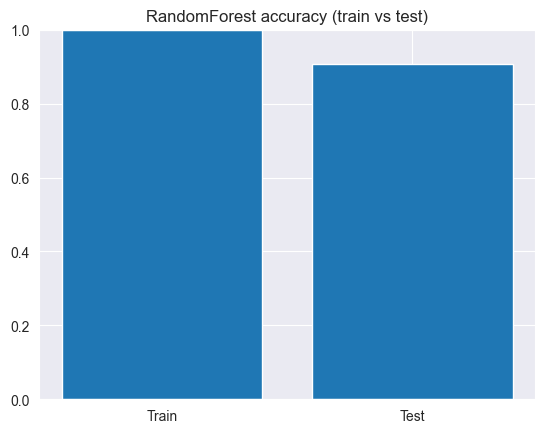

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# accuracy sur le train
y_pred_train = best_rf.predict(X_train_scaled)
train_acc = accuracy_score(y_train_flat, y_pred_train)

# accuracy sur le test
y_pred_test = best_rf.predict(X_test_scaled)
test_acc = accuracy_score(y_test_flat, y_pred_test)

print("Train accuracy:", train_acc)
print("Test accuracy :", test_acc)

# petit graphique
plt.bar(['Train', 'Test'], [train_acc, test_acc])
plt.ylim(0, 1)
plt.title("RandomForest accuracy (train vs test)")
plt.show()


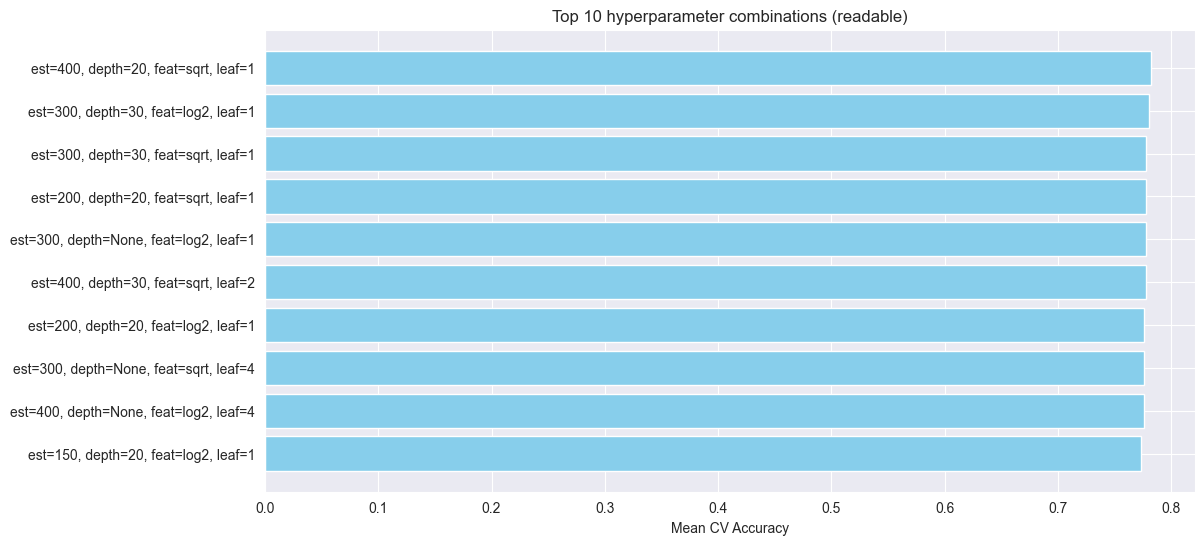

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(search.cv_results_)

# On trie les résultats
top10 = results.sort_values(by="mean_test_score", ascending=False).head(10)

# On construit une étiquette lisible pour chaque combinaison
labels = []
for i, row in top10.iterrows():
    combo = (
        f"est={row['param_n_estimators']}, "
        f"depth={row['param_max_depth']}, "
        f"feat={row['param_max_features']}, "
        f"leaf={row['param_min_samples_leaf']}"
    )
    labels.append(combo)

plt.figure(figsize=(12, 6))
plt.barh(labels, top10["mean_test_score"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean CV Accuracy")
plt.title("Top 10 hyperparameter combinations (readable)")
plt.show()



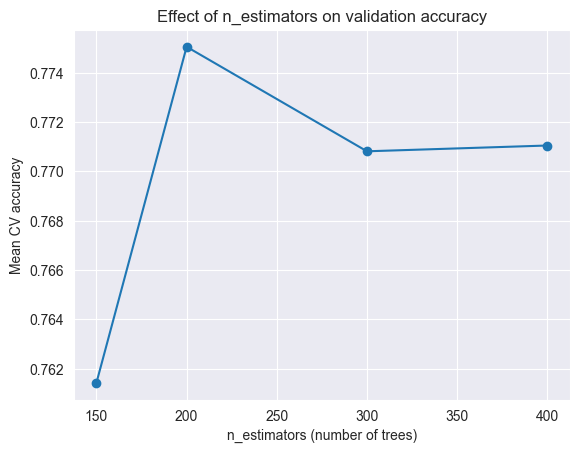

In [ ]:
grouped = results.groupby('param_n_estimators')['mean_test_score'].mean()

plt.plot(grouped.index, grouped.values, marker='o')
plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Mean CV accuracy")
plt.title("Effect of n_estimators on validation accuracy")
plt.show()


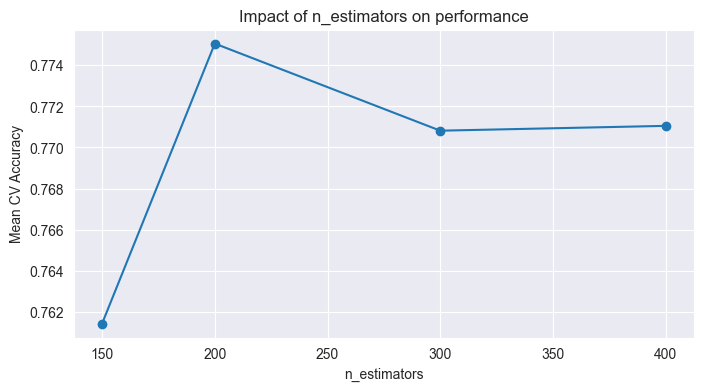

In [ ]:
grouped = results.groupby('param_n_estimators')['mean_test_score'].mean()

plt.figure(figsize=(8,4))
plt.plot(grouped.index, grouped.values, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Accuracy")
plt.title("Impact of n_estimators on performance")
plt.grid(True)
plt.show()


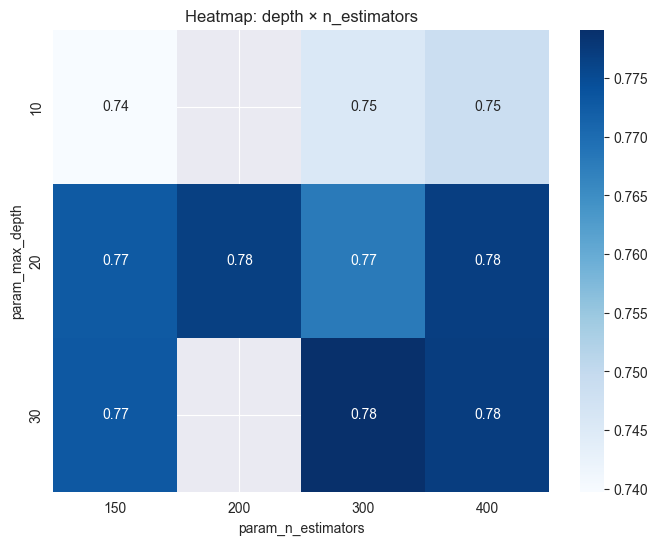

In [ ]:
import seaborn as sns
pivot = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, cmap="Blues")
plt.title("Heatmap: depth × n_estimators")
plt.show()
